# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [18]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
%reload_ext autoreload
# %autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [19]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [20]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.3
Mean of input:  9.999966383163867
Mean of train-time output:  9.994467118170617
Mean of test-time output:  9.999966383163867
Fraction of train-time output set to zero:  0.300396
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  9.999966383163867
Mean of train-time output:  10.024934076902415
Mean of test-time output:  9.999966383163867
Fraction of train-time output set to zero:  0.599016
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  9.999966383163867
Mean of train-time output:  9.978814612737434
Mean of test-time output:  9.999966383163867
Fraction of train-time output set to zero:  0.750476
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [21]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
print('x:{}'.format(x))
dx = dropout_backward(dout, cache)
print('dx:{}'.format(dx))
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

x:[[ 8.61638705  9.81118306  9.1542256   8.94052644 12.49551057  9.66358636
   9.07770315  9.26840819  9.36404174 11.23508548]
 [11.21409983  9.93729844 10.03093276 11.20266797  9.37953489 10.52220489
   9.32263609 10.52422581 12.12529517  8.39241933]
 [ 9.05425228  8.57649418 10.64833146 10.6297234   9.072729   10.51126789
   8.46350179  9.25918704  8.84525806  9.04859636]
 [10.7595572  10.74353937  8.90716645 10.32326294  8.16328725 10.42685754
   8.68376295  8.65671609 10.01242683  9.46933708]
 [ 9.39953592  9.24897753 10.65229722  9.7620057   8.78757033 10.75732934
   9.65588135 11.43793013 10.32248563  8.87913756]
 [11.30536808  9.67669903 11.26428195 10.39943177 10.3711215   8.30383613
   9.45530617  9.77259768  8.15820352  9.67805036]
 [10.53686382  9.59893101  9.44717791 10.77516243 10.85885656  8.52368335
   9.21921602  8.59743853  8.89376568 10.29442743]
 [10.32787693 10.37969192  9.6818772   9.6347055  10.01072028 10.14444867
   8.51086369  7.64890674  8.99256011  9.77695832

# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [35]:
# input hiddlen1 hiddlen2 out
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.0173141694218577
W1 relative error: 4.83e-07
W2 relative error: 1.39e-07
W3 relative error: 1.54e-06
b1 relative error: 2.03e-08
b2 relative error: 7.29e-10
b3 relative error: 1.71e-09

Running check with dropout =  0.25
Initial loss:  1.7762205177153843
W1 relative error: 2.17e-08
W2 relative error: 7.51e-09
W3 relative error: 8.00e-08
b1 relative error: 2.92e-10
b2 relative error: 8.63e-11
b3 relative error: 1.93e-10

Running check with dropout =  0.5
Initial loss:  2.5170009333750327
W1 relative error: 6.73e-09
W2 relative error: 1.90e-08
W3 relative error: 3.71e-07
b1 relative error: 5.61e-11
b2 relative error: 5.11e-10
b3 relative error: 4.19e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [44]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.5, 0.75, 0.9]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0


D:\ML\cs231n\assignment2\cs231n\layers.py:681: RuntimeWarning: divide by zero encountered in log
  Returns a tuple of:


(Iteration 1 / 125) loss: inf
(Epoch 0 / 25) train acc: 0.182000; val_acc: 0.163000
(Epoch 1 / 25) train acc: 0.344000; val_acc: 0.254000
(Epoch 2 / 25) train acc: 0.506000; val_acc: 0.253000
(Epoch 3 / 25) train acc: 0.536000; val_acc: 0.243000
(Epoch 4 / 25) train acc: 0.652000; val_acc: 0.288000
(Epoch 5 / 25) train acc: 0.736000; val_acc: 0.256000
(Epoch 6 / 25) train acc: 0.768000; val_acc: 0.284000
(Epoch 7 / 25) train acc: 0.830000; val_acc: 0.307000
(Epoch 8 / 25) train acc: 0.862000; val_acc: 0.275000
(Epoch 9 / 25) train acc: 0.844000; val_acc: 0.270000
(Epoch 10 / 25) train acc: 0.906000; val_acc: 0.297000
(Epoch 11 / 25) train acc: 0.920000; val_acc: 0.306000
(Epoch 12 / 25) train acc: 0.920000; val_acc: 0.290000
(Epoch 13 / 25) train acc: 0.958000; val_acc: 0.291000
(Epoch 14 / 25) train acc: 0.972000; val_acc: 0.292000
(Epoch 15 / 25) train acc: 0.964000; val_acc: 0.290000
(Epoch 16 / 25) train acc: 0.976000; val_acc: 0.291000
(Epoch 17 / 25) train acc: 0.982000; val_acc:

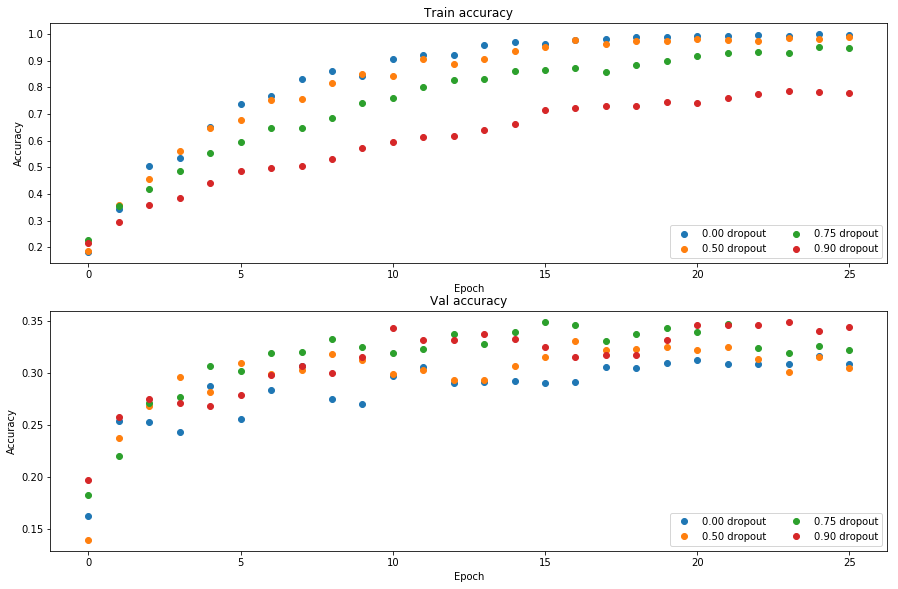

In [45]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
Dropout can alleviate overfitting.